# Mouse Olfactory Bulb Analysis

**Date** : 2021-10-05<br>
**Author** : Alma Andersson<br>
**Description** : <br>
This notebook outlines the analysis related to the Mouse Olfactory Bulb (MOB) data.

Load necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc

import os.path as osp
import os
from PIL import Image

import anndata as ad
import pandas as pd
import sys

import eggplant as eg



Set plotting parameters

In [2]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "None"
rcParams["axes.facecolor"] = "None"

## Load and process Reference Information

Define paths to data and reference images

In [3]:
DATA_DIR = "../data/mob/curated/"
REF_IMG_PTH = "../data/mob/references/reference.png"
REF_LMK_PTH = "../data/mob/references/landmarks.tsv"

Load reference image

In [4]:
ref_img = Image.open(REF_IMG_PTH)
ref_lmk = pd.read_csv(REF_LMK_PTH,sep="\t",header = 0,index_col =0)

Inspect the reference image to make sure we loaded the correct image. Also plot the landmark coordinates to ensure that these match the reference.

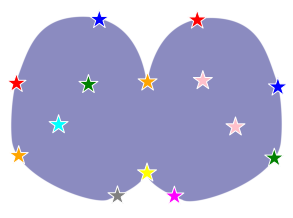

In [5]:
plt.figure(figsize = (5,5))
lmk_cmap = eg.constants.LANDMARK_CMAP
cmap = eg.pl.ColorMapper(lmk_cmap)

plt.imshow(ref_img,alpha = 0.7)
plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            edgecolor = "white",
            c = cmap(ref_lmk),
            s = 400,
           )
plt.axis("off")
plt.show()

Everything seems fine with the reference and landmark coordinates. We therefore proceed to convert the image to a grid with associated meta data (which region each grid point belongs to). The number of points in the grid will be close to `n_approx_points`, the more points, the higher the resolution. The argument `n_regions`specifies how many regions we have defined, by different colors, in our reference.

In [6]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                    n_approx_points=1000,
                                    n_regions=1,
                                   )

We also plot the newly created grid to make sure it looks as we'd expect it to. We can again overlay the landmarks.

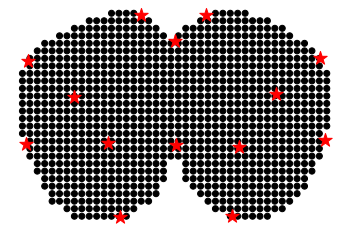

In [7]:
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c= mta,
            cmap = plt.cm.binary_r,
           )

plt.scatter(ref_lmk.values[:,0],
            ref_lmk.values[:,1],
            marker = "*",
            c = "red",
            s = 200,
           )

plt.axis("equal")
plt.axis("off")
plt.show()

From the grid and landmarks we may now create a `Reference` object, which will be used in the transfer process.

In [8]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                     meta = dict(region = mta),
                    )

## Load and process Expression Data

First, we load the anndata files from the designated data directory `DATA_DIR`

In [9]:
adatas = {p.split(".")[0]:ad.read_h5ad(osp.join(DATA_DIR,p)) for p in os.listdir(DATA_DIR)}
adatas = {f"Rep{k}_MOB" : adatas[f"Rep{k}_MOB"] for k \
          in sorted([ int(a.lstrip("Rep_").rstrip("_MOB")) for a in adatas.keys()])}

Next, we execute some standard pre-processing steps such as filter, normalize, log-transform, and scaling. However, we also match the scales between the observed data and the reference (`match_scales`), after which we compute the distance for every spot to each landmark (`get_landmark_distance`). We supply the aforementioned function with the reference object, to conduct TPS warping and thus account for non-homogenous disruptions in the morphology.

In [10]:
for adata in adatas.values():
    eg.pp.default_normalization(adata,
                                min_cells = 0.1,
                                total_counts = 1e4,
                                exclude_highly_expressed=False)
    
    eg.pp.match_scales(adata,ref)
    eg.pp.get_landmark_distance(adata,
                                reference=ref)    

    eg.pp.spatial_smoothing(adata)


/home/alma/miniconda3/envs/eggplant/lib/python3.8/site-packages/scanpy-1.8.2-py3.8.egg/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


As is proper, we then inspect our processed data to see that everything looks as expected.

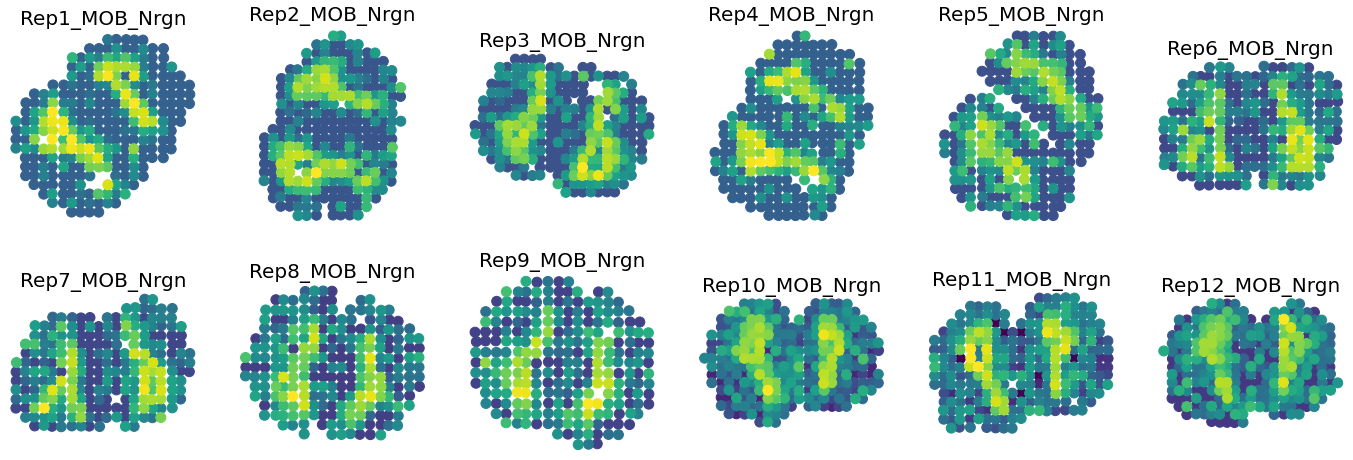

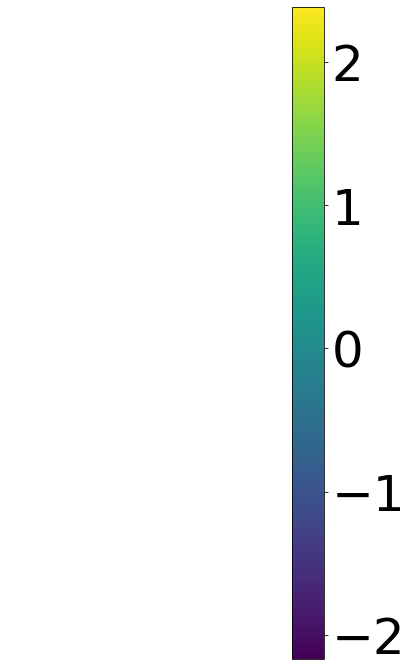

In [11]:
eg.pl.visualize_observed(adatas,
                         features = "Nrgn",
                         n_rows = 2,
                         include_title = True,
                         fontsize = 20,
                         marker_size =100,
                         share_colorscale = True,
                         separate_colorbar = True,
                         side_size = 4,
                         show_landmarks = False,
                         quantile_scaling = True,
                        )

We now transfer our data to the reference using the `transfer_to_reference` function. Here we use the gene _Nrgn_ as our target of interest, but this may be exchanged for any of the other two genes presented in the supplementary (or any gene of the users liking). We use $1000$ epochs and `cuda` acceleration, if possible. We also set `verbose=True` in order to be able to follow the progress.

In [12]:
help(eg.fun.transfer_to_reference)

Help on function transfer_to_reference in module eggplant.methods:

transfer_to_reference(adatas: Union[anndata._core.anndata.AnnData, List[anndata._core.anndata.AnnData], Dict[str, anndata._core.anndata.AnnData]], features: Union[str, List[str]], reference: eggplant.models.Reference, layer: Union[str, NoneType] = None, device: Literal['cpu', 'gpu'] = 'cpu', n_epochs: int = 1000, learning_rate: float = 0.01, subsample: Union[float, int, NoneType] = None, verbose: bool = False, return_models: bool = False, return_losses: bool = True, max_cg_iterations: int = 1000, meta_key: str = 'meta', inference_method: Union[Literal['exact', 'variational'], List[Literal['exact', 'variational']], Dict[str, Literal['exact', 'variational']]] = 'exact', n_inducing_points: int = None, batch_size: Union[int, NoneType] = None, **kwargs) -> Dict[str, Union[List[ForwardRef('m.GPModel')], List[numpy.ndarray]]]
    transfer observed data to a reference
    
    :param adatas: AnnData objects holding data to tra

In [13]:
losses = eg.fun.transfer_to_reference(adatas,
                                      reference=ref,
                                      layer = "smoothed",
                                      features = ["Nrgn","Apoe","Omp"],
                                      n_epochs=1000,
                                      device ="cpu",
                                      verbose=True,
                                     inference_method = "variational",
                                     )

[Processing] ::  Model : Rep1_MOB | Feature : Nrgn | Transfer : 1/36
[WARNING] : You're using approximate (variational) inference on a small data set (267 observations)


  0%|                                                                                                          | 0/1000 [00:00<?, ?it/s]/home/alma/miniconda3/envs/eggplant/lib/python3.8/site-packages/torch-1.10.0-py3.8-linux-x86_64.egg/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.65it/s]


[Processing] ::  Model : Rep1_MOB | Feature : Apoe | Transfer : 2/36


/home/alma/miniconda3/envs/eggplant/lib/python3.8/site-packages/anndata-0.7.6-py3.8.egg/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.08it/s]


[Processing] ::  Model : Rep1_MOB | Feature : Omp | Transfer : 3/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.76it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Nrgn | Transfer : 4/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.91it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Apoe | Transfer : 5/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.91it/s]


[Processing] ::  Model : Rep2_MOB | Feature : Omp | Transfer : 6/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.19it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Nrgn | Transfer : 7/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.25it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Apoe | Transfer : 8/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


[Processing] ::  Model : Rep3_MOB | Feature : Omp | Transfer : 9/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.94it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Nrgn | Transfer : 10/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.45it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Apoe | Transfer : 11/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.93it/s]


[Processing] ::  Model : Rep4_MOB | Feature : Omp | Transfer : 12/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.55it/s]


[Processing] ::  Model : Rep5_MOB | Feature : Nrgn | Transfer : 13/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.99it/s]


[Processing] ::  Model : Rep5_MOB | Feature : Apoe | Transfer : 14/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.58it/s]

[Processing] ::  Model : Rep5_MOB | Feature : Omp | Transfer : 15/36



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.10it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Nrgn | Transfer : 16/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.00it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Apoe | Transfer : 17/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.74it/s]


[Processing] ::  Model : Rep6_MOB | Feature : Omp | Transfer : 18/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.12it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Nrgn | Transfer : 19/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.38it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Apoe | Transfer : 20/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.09it/s]


[Processing] ::  Model : Rep7_MOB | Feature : Omp | Transfer : 21/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.42it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Nrgn | Transfer : 22/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.41it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Apoe | Transfer : 23/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.03it/s]


[Processing] ::  Model : Rep8_MOB | Feature : Omp | Transfer : 24/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.11it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Nrgn | Transfer : 25/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.82it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Apoe | Transfer : 26/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.09it/s]


[Processing] ::  Model : Rep9_MOB | Feature : Omp | Transfer : 27/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.90it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Nrgn | Transfer : 28/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.21it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Apoe | Transfer : 29/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.26it/s]


[Processing] ::  Model : Rep10_MOB | Feature : Omp | Transfer : 30/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.99it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Nrgn | Transfer : 31/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.77it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Apoe | Transfer : 32/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.40it/s]


[Processing] ::  Model : Rep11_MOB | Feature : Omp | Transfer : 33/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.01it/s]


[Processing] ::  Model : Rep12_MOB | Feature : Nrgn | Transfer : 34/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.46it/s]

[Processing] ::  Model : Rep12_MOB | Feature : Apoe | Transfer : 35/36



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.16it/s]


[Processing] ::  Model : Rep12_MOB | Feature : Omp | Transfer : 36/36


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Having fitted our models, we now inspect their respective losses - to control for any unexpected abberrations - and find that all our curves look as we would expect them to as well as seeming to have converged.

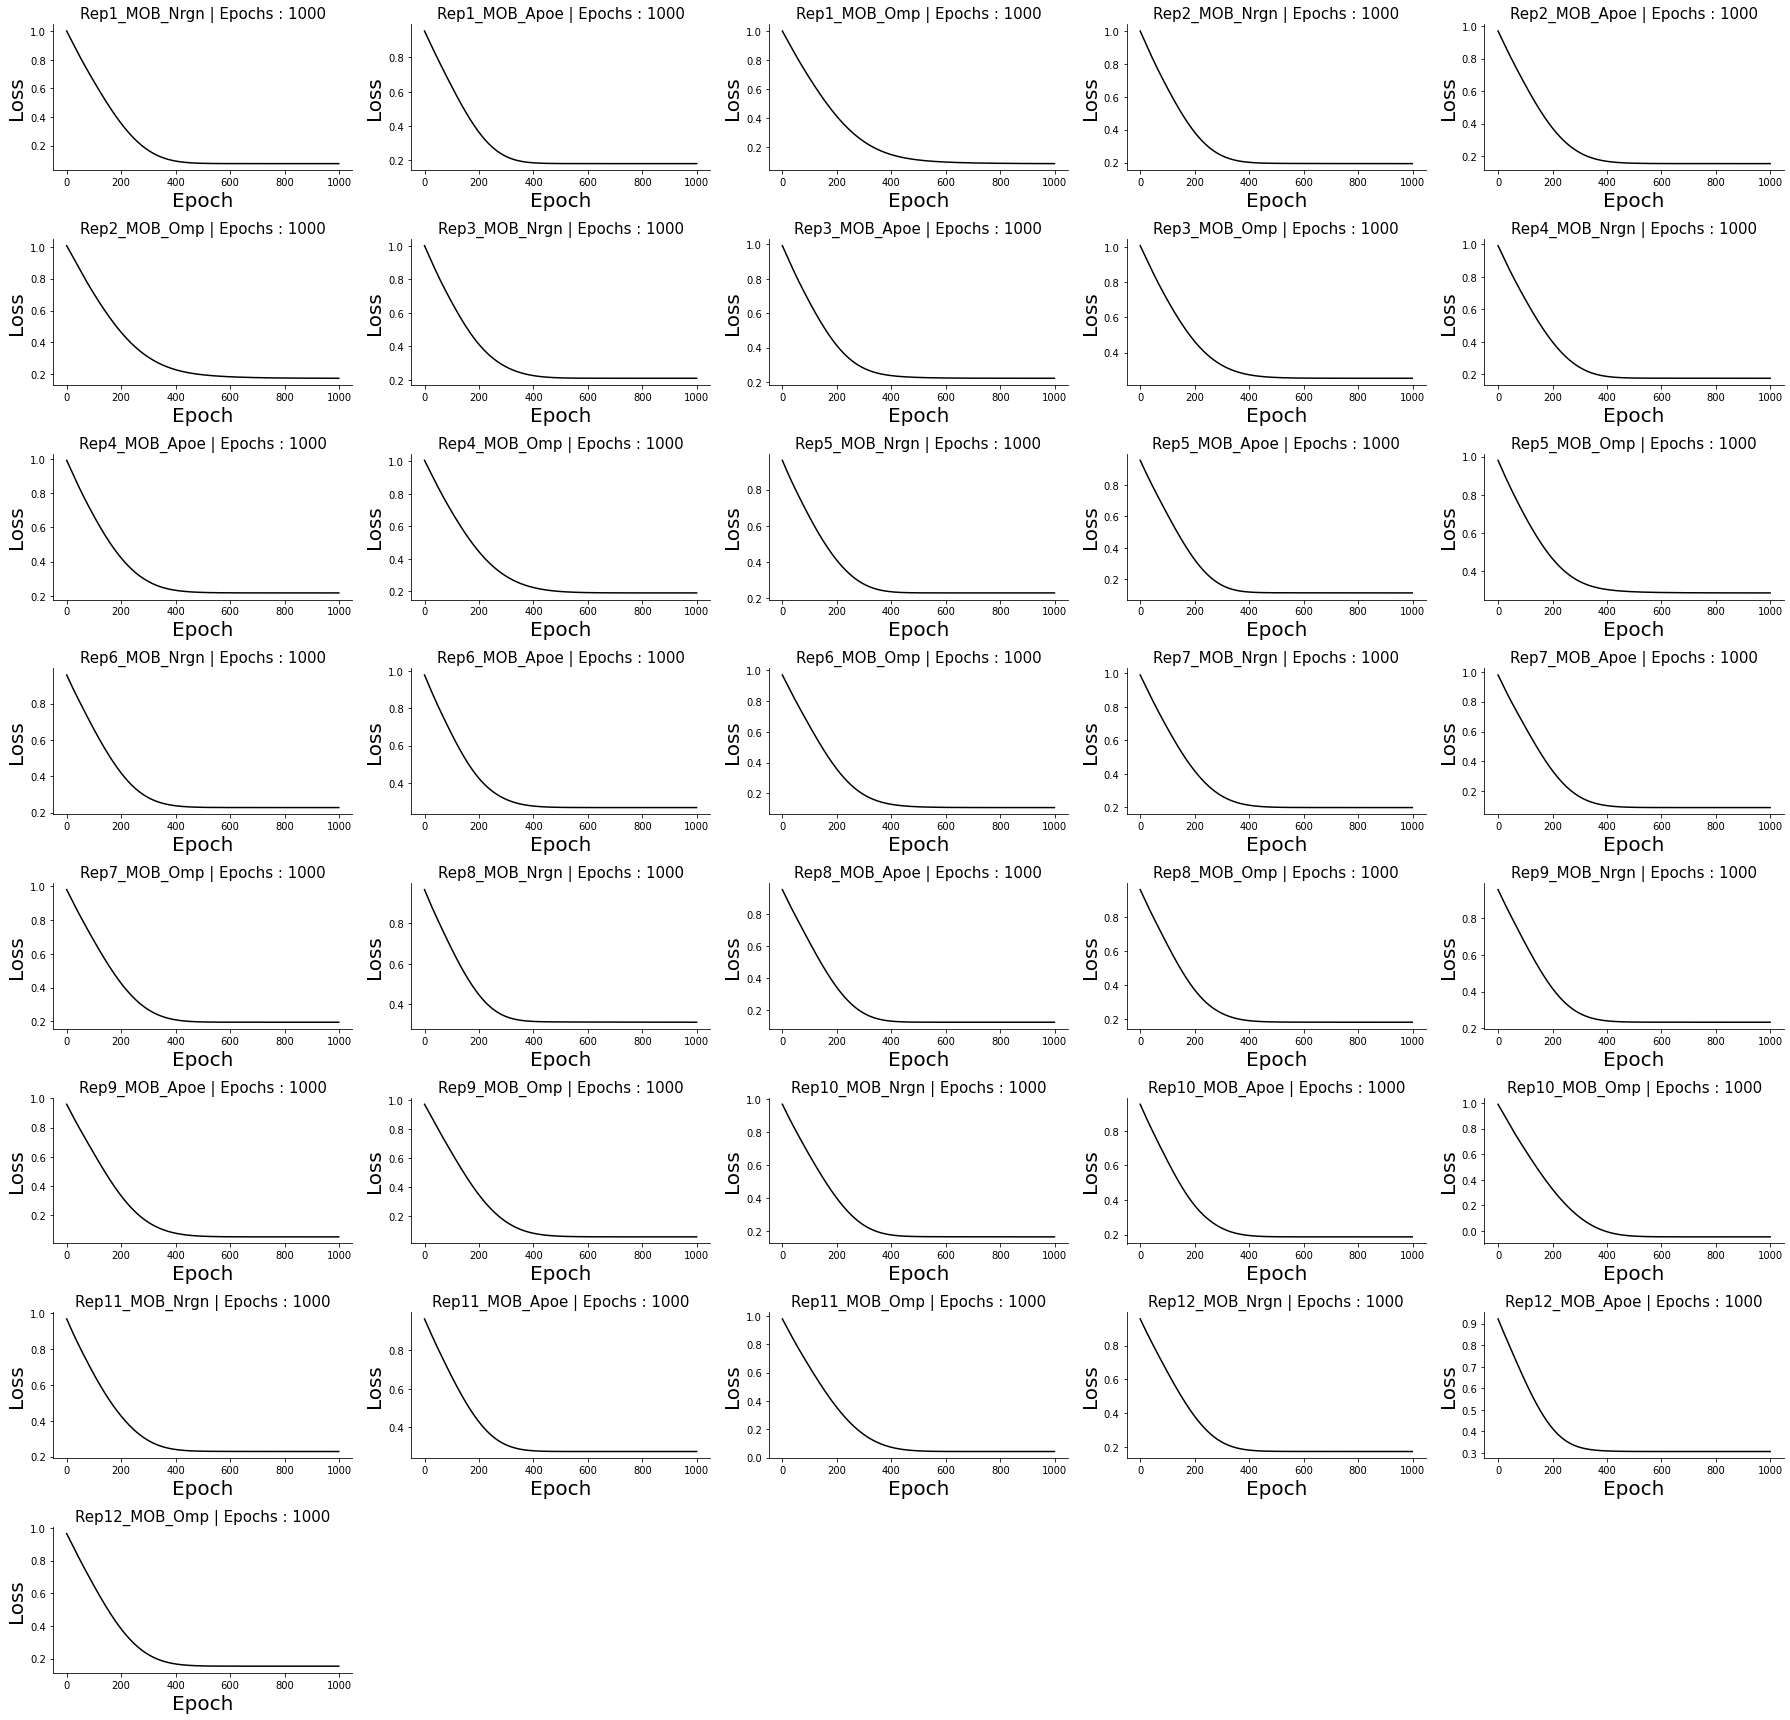

In [16]:
eg.pl.model_diagnostics(losses = losses)

Finally, we visualize our results

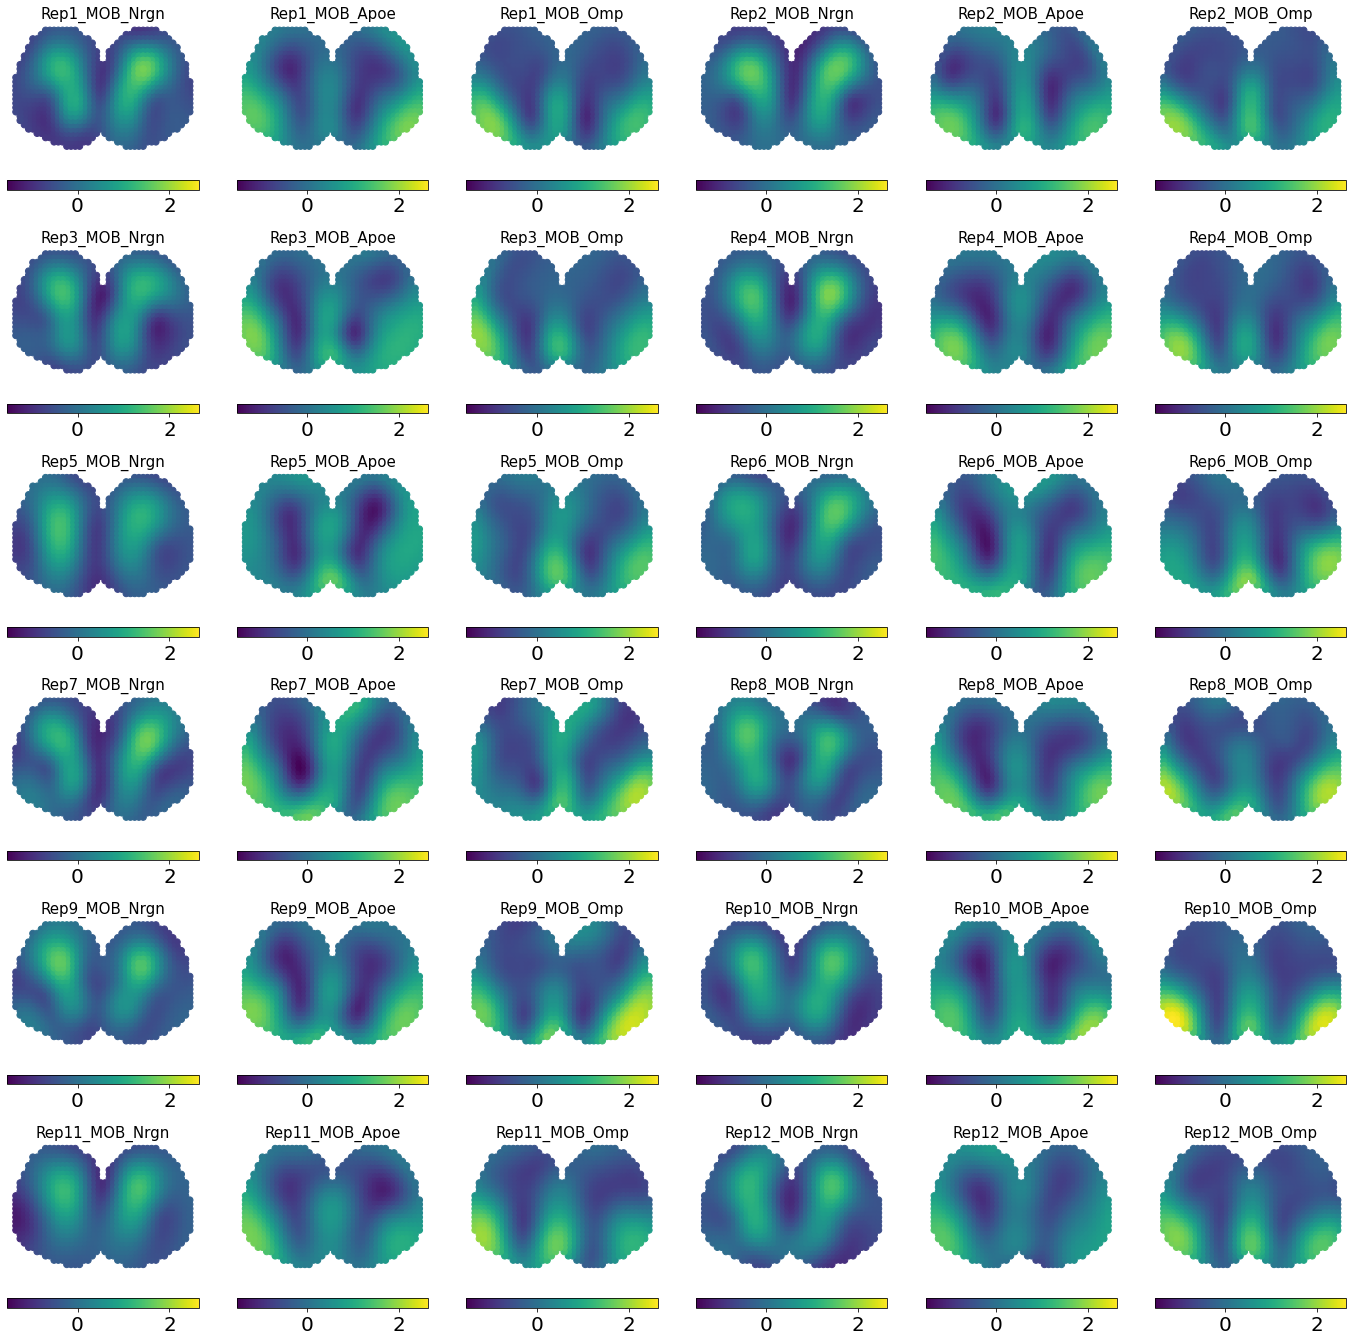

In [14]:
eg.pl.visualize_transfer(ref,
                         n_cols = 6,
                         include_title = True,
                         fontsize = 15,
                         marker_size =40,
                         share_colorscale = True,
                         separate_colorbar = False,
                         colorbar_fontsize = 20,
                         side_size = 4,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )

Next, we conduct a *spatial differential gene expression analysis* (SDEA), with respect to the gene expression. If the interval of $[\mu - 2\sigma, \mu + 2\sigma]$ between any two features overalap at a spatial location, we consider their expression not significantly differentially expressed.

In [18]:
res = eg.sdea.sdea(ref.adata,
                   group_col="feature",
                   n_std=2,
                  )

We visualize the results from our SDEA, gray areas indicate locations with no significant differential expression, color regions is the difference between the two compared features' expression

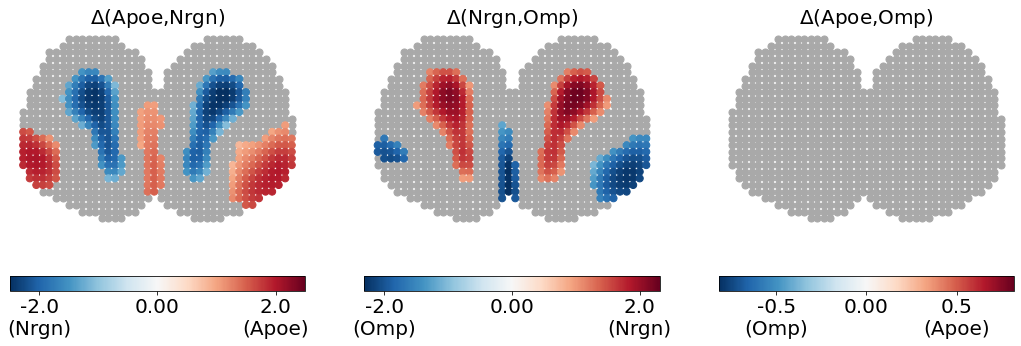

In [19]:
fig,ax = eg.pl.visualize_sdea_results(ref,
                                     res,
                                     n_cols = 3,
                                     marker_size = 50,
                                     side_size = 6,
                                     colorbar_orientation ="horizontal",
                                     title_fontsize = 20,
                                     colorbar_fontsize = 20,
                                     no_sig_color = "darkgray",
                                     reorder_axes = [0,2,1],
                                    )

Finally, we generate composite representations and visualize them

In [20]:
ref.composite_representation(by = "feature")

/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/utils.py:141: UserWarning: Layer 'var' converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


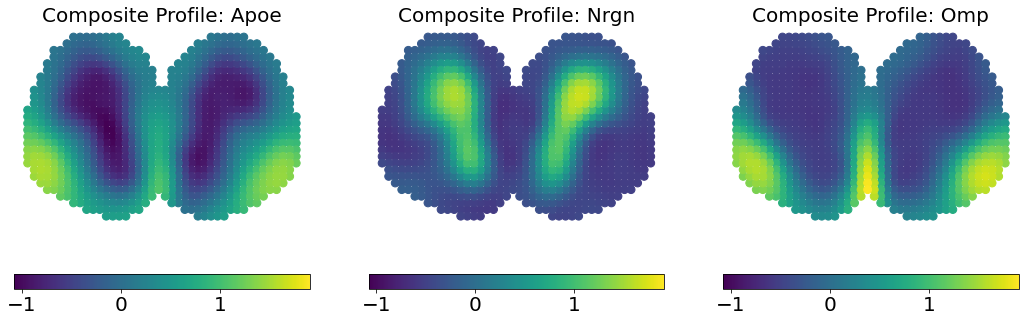

In [21]:
eg.pl.visualize_transfer(ref,
                         attributes = "composite",
                         n_cols = 3,
                         include_title = True,
                         fontsize = 20,
                         colorbar_fontsize = 20,
                         marker_size =62,
                         share_colorscale = True,
                         separate_colorbar = False,
                         side_size = 6,
                         show_landmarks = False,
                         flip_y = True,
                         quantile_scaling = False,
                        )